In [2]:
import arviz
import pandas as pd
from ..model_builder import ModelBuilder
from ..utils.posteriorplots import predictive_plot, retrodictive_plot

ImportError: attempted relative import with no known parent package

In [4]:
from ..utils 

ImportError: attempted relative import with no known parent package

In [2]:
arviz.style.use("arviz-darkgrid")

In [3]:
from utils.model_builder import ModelBuilder

In [4]:
from utils.posteriorplots import predictive_plot, retrodictive_plot

In [2]:
%load_ext autoreload
%autoreload 2

## Model with socio-eco predictors

- https://fivethirtyeight.com/features/how-fivethirtyeights-2020-presidential-forecast-works-and-whats-different-because-of-covid-19/
-    Jobs, as indicated by nonfarm payrolls.
    Spending, as indicated by real personal consumption expenditures.
    Income, as measured by real disposable personal income.
    Manufacturing, as measured by industrial production.
    Inflation, based on the consumer price index.9
    And the stock market, based on the S&P 500.

In [24]:
TEST_CUTOFF = pd.Timedelta(8, "W")
mb = ModelBuilder(election_to_predict="2017-04-23", test_cutoff=TEST_CUTOFF)
hierarchical_dm = mb.build_model()

/Users/alex_andorra/repos/pollsposition/models/presidential-elections/model_builder.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["countdown"] = dates_to_idx(df["date"], reference_date=date).astype(int)


In [20]:
mb.election_incumbent

farleft  left  green  center  right  farright  other
0        0     0      0       0      1         0      0
1        0     0      0       0      1         0      0
2        0     0      0       0      1         0      0
3        0     1      0       0      0         0      0

In [23]:
pd.DataFrame(
    np.repeat(
        mb.election_incumbent.to_numpy(), repeats=len(mb.coords["countdown"]), axis=0
    ),
    columns=mb.parties_complete,
)

farleft  left  green  center  right  farright  other
0          0     0      0       0      1         0      0
1          0     0      0       0      1         0      0
2          0     0      0       0      1         0      0
3          0     0      0       0      1         0      0
4          0     0      0       0      1         0      0
..       ...   ...    ...     ...    ...       ...    ...
435        0     1      0       0      0         0      0
436        0     1      0       0      0         0      0
437        0     1      0       0      0         0      0
438        0     1      0       0      0         0      0
439        0     1      0       0      0         0      0

[440 rows x 7 columns]

In [25]:
idata_hierarchical_dm = mb.sample_all(
    var_names=[
        "latent_popularity",
        "latent_pop_t0",
        "R",
        "noisy_popularity",
        "N_approve",
    ],
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [concentration, election_party_time_coefs, party_time_coefs_raw, lsd_election_party_raw, lsd_election_party_sd, lsd_election_effect, lsd_party_effect_2, lsd_party_effect_1, lsd_intercept, incumbency_popularity_effect, popularity_effect, gas_effect, unemployment_effect, house_election_effects_raw, house_election_effect_sd, house_effects, election_party_intercept, election_party_intercept_sd, party_intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 699 seconds.
The number of effective samples is smaller than 25% for some parameters.


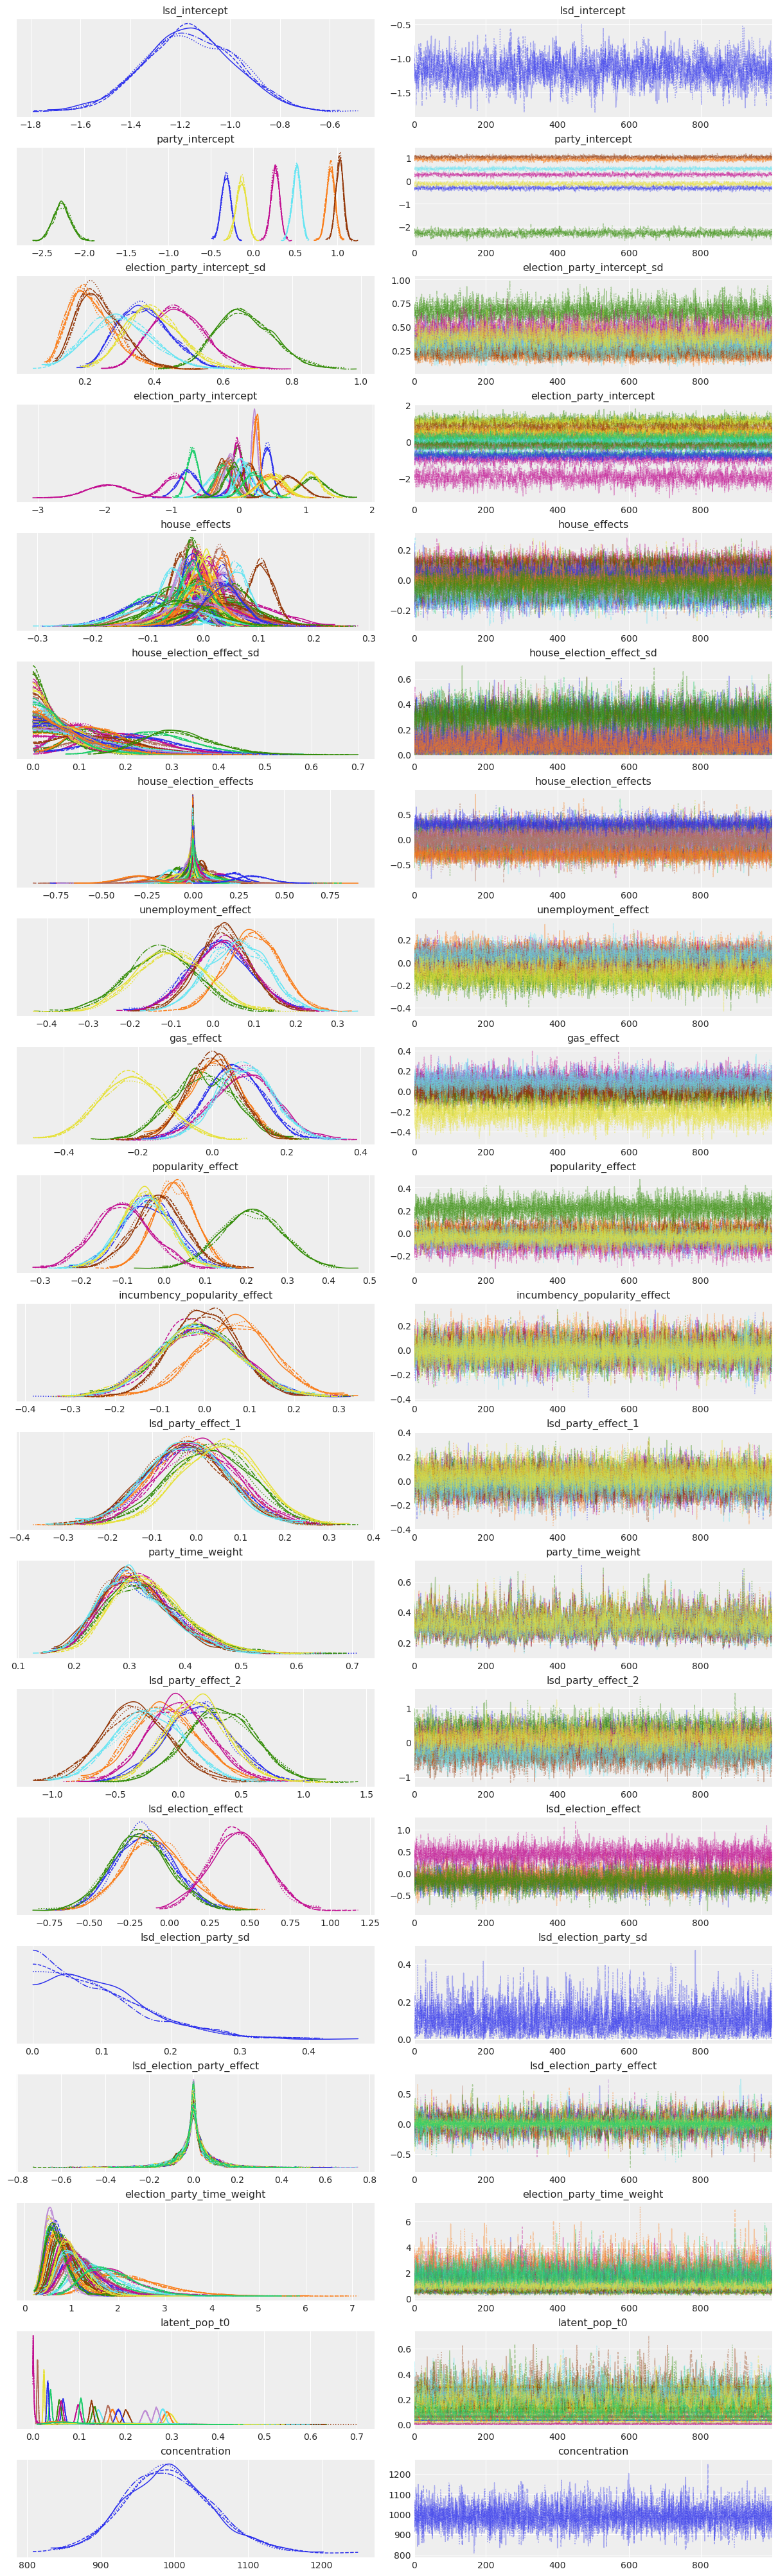

In [26]:
arviz.plot_trace(
    idata_hierarchical_dm,
    var_names=[
        "~time_effect",
        "~time_coefs",
        "~latent_popularity",
        "~noisy_popularity",
        "~raw",
    ],
    filter_vars="regex",
);

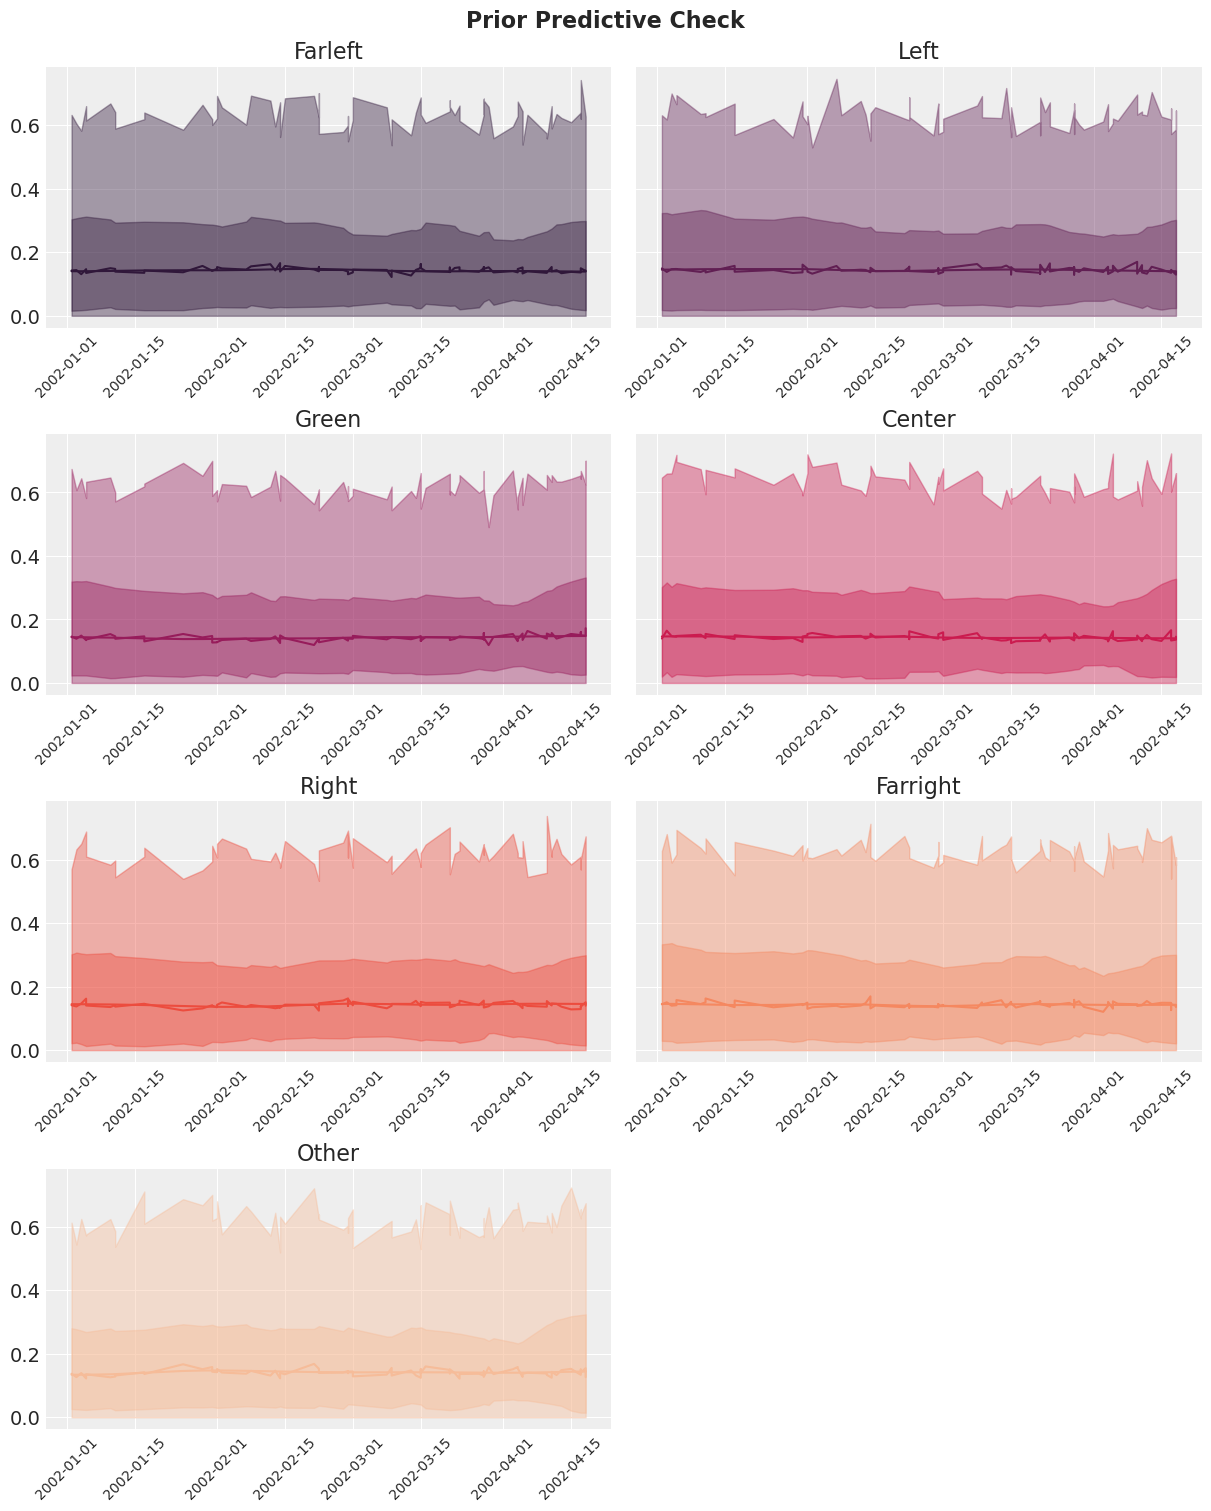

In [63]:
retrodictive_plot(
    idata_hierarchical_dm.sel(
        elections="2002-04-21",
        observations=polls_train[polls_train.dateelection == "2002-04-21"].index,
    ),
    PARTIES_COMPLETE,
    polls_train[polls_train.dateelection == "2002-04-21"],
    group="prior",
)

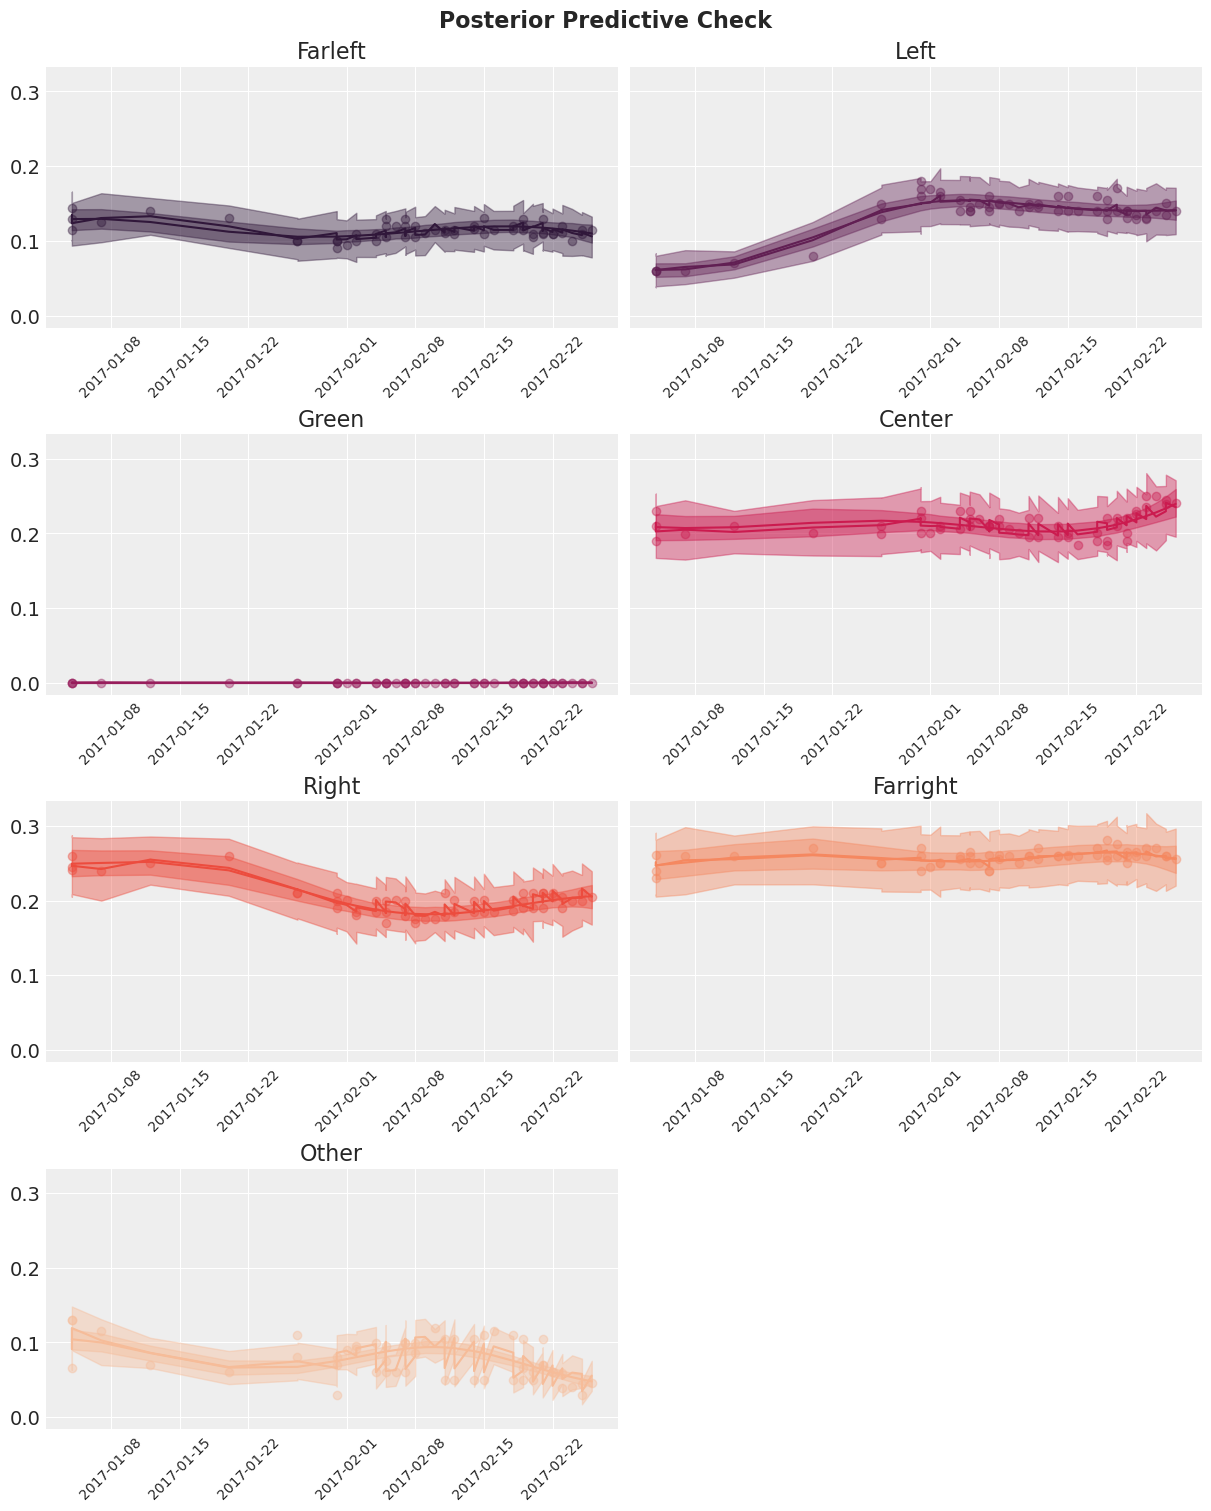

In [27]:
election_date = "2017-04-23"
polls_train = mb.polls_train.copy()
retrodictive_plot(
    idata_hierarchical_dm.sel(
        elections=election_date,
        observations=polls_train[polls_train.dateelection == election_date].index,
    ),
    mb.parties_complete,
    polls_train[polls_train.dateelection == election_date],
    group="posterior",
)

In [28]:
election_forecast = mb.forecast_election(idata_hierarchical_dm)

In [59]:
polls_train.dateelection.unique()

array(['2002-04-21T00:00:00.000000000', '2007-04-22T00:00:00.000000000',
       '2012-04-22T00:00:00.000000000', '2017-04-23T00:00:00.000000000'],
      dtype='datetime64[ns]')

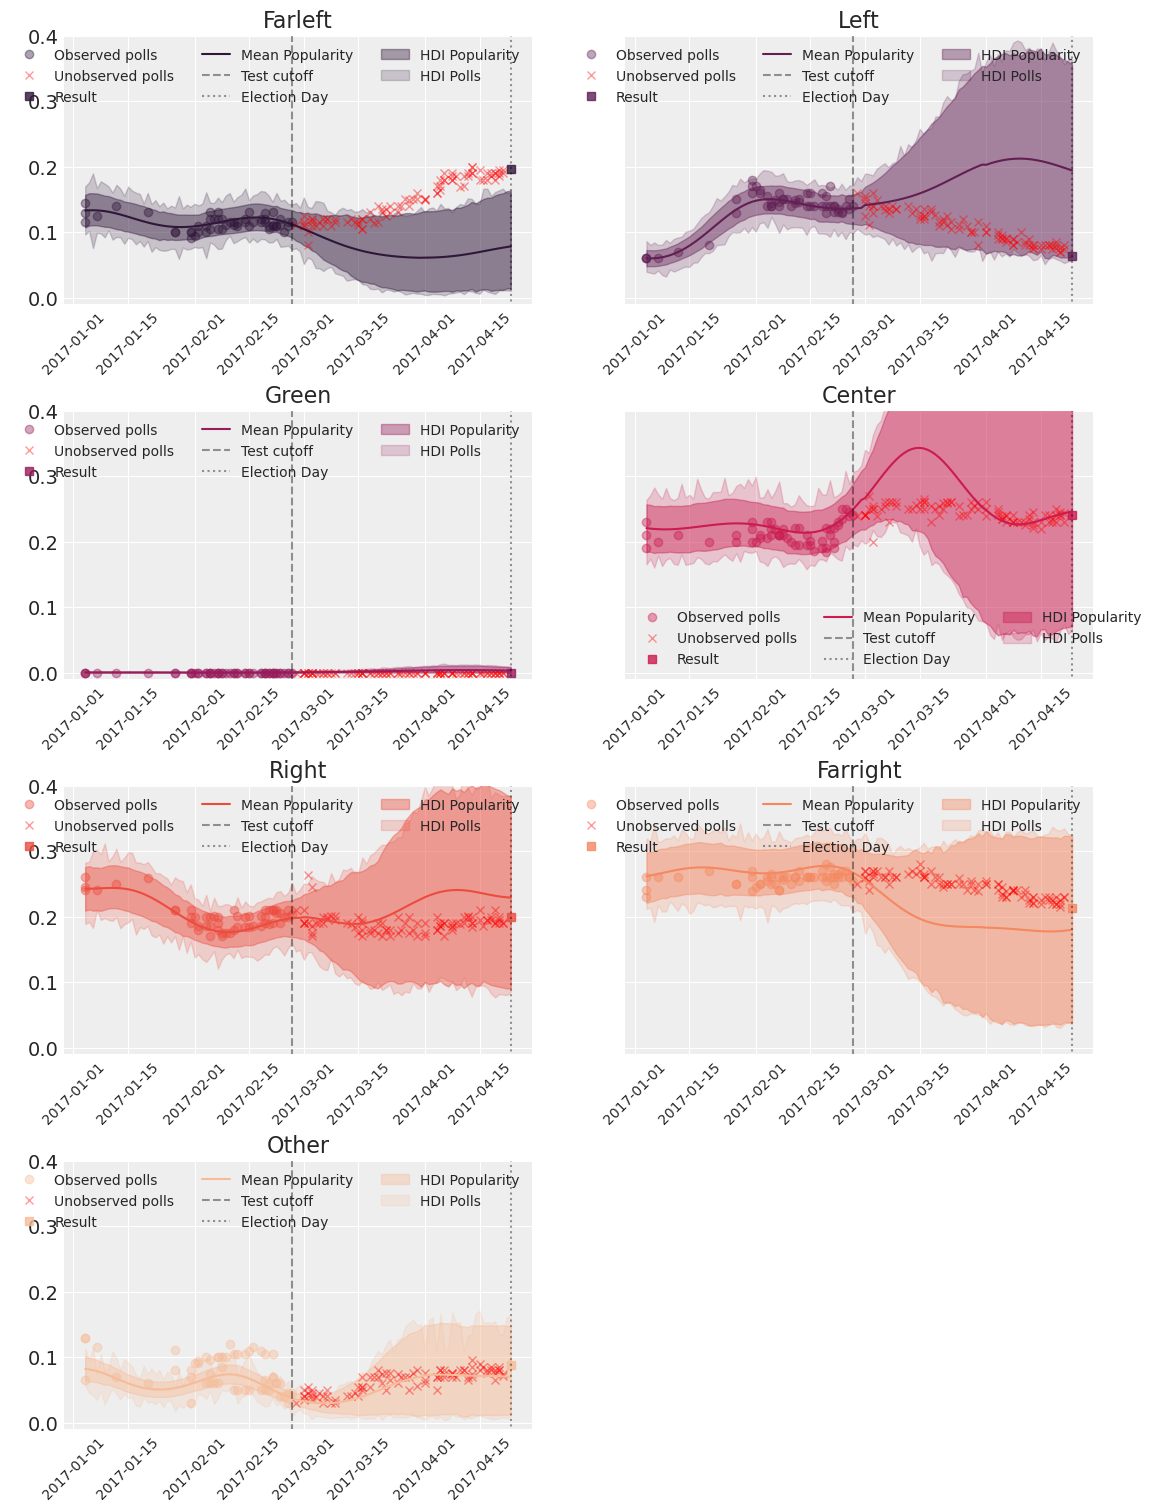

In [29]:
election_date = "2017-04-23"
results = mb.results_raw
polls_test = mb.polls_test

predictive_plot(
    election_forecast,
    mb.parties_complete,
    election_date,
    results[results.dateelection == election_date],
    polls_train[polls_train.dateelection == election_date],
    polls_test[polls_test.dateelection == election_date],
    TEST_CUTOFF,
)
# plt.savefig("ppc.png")

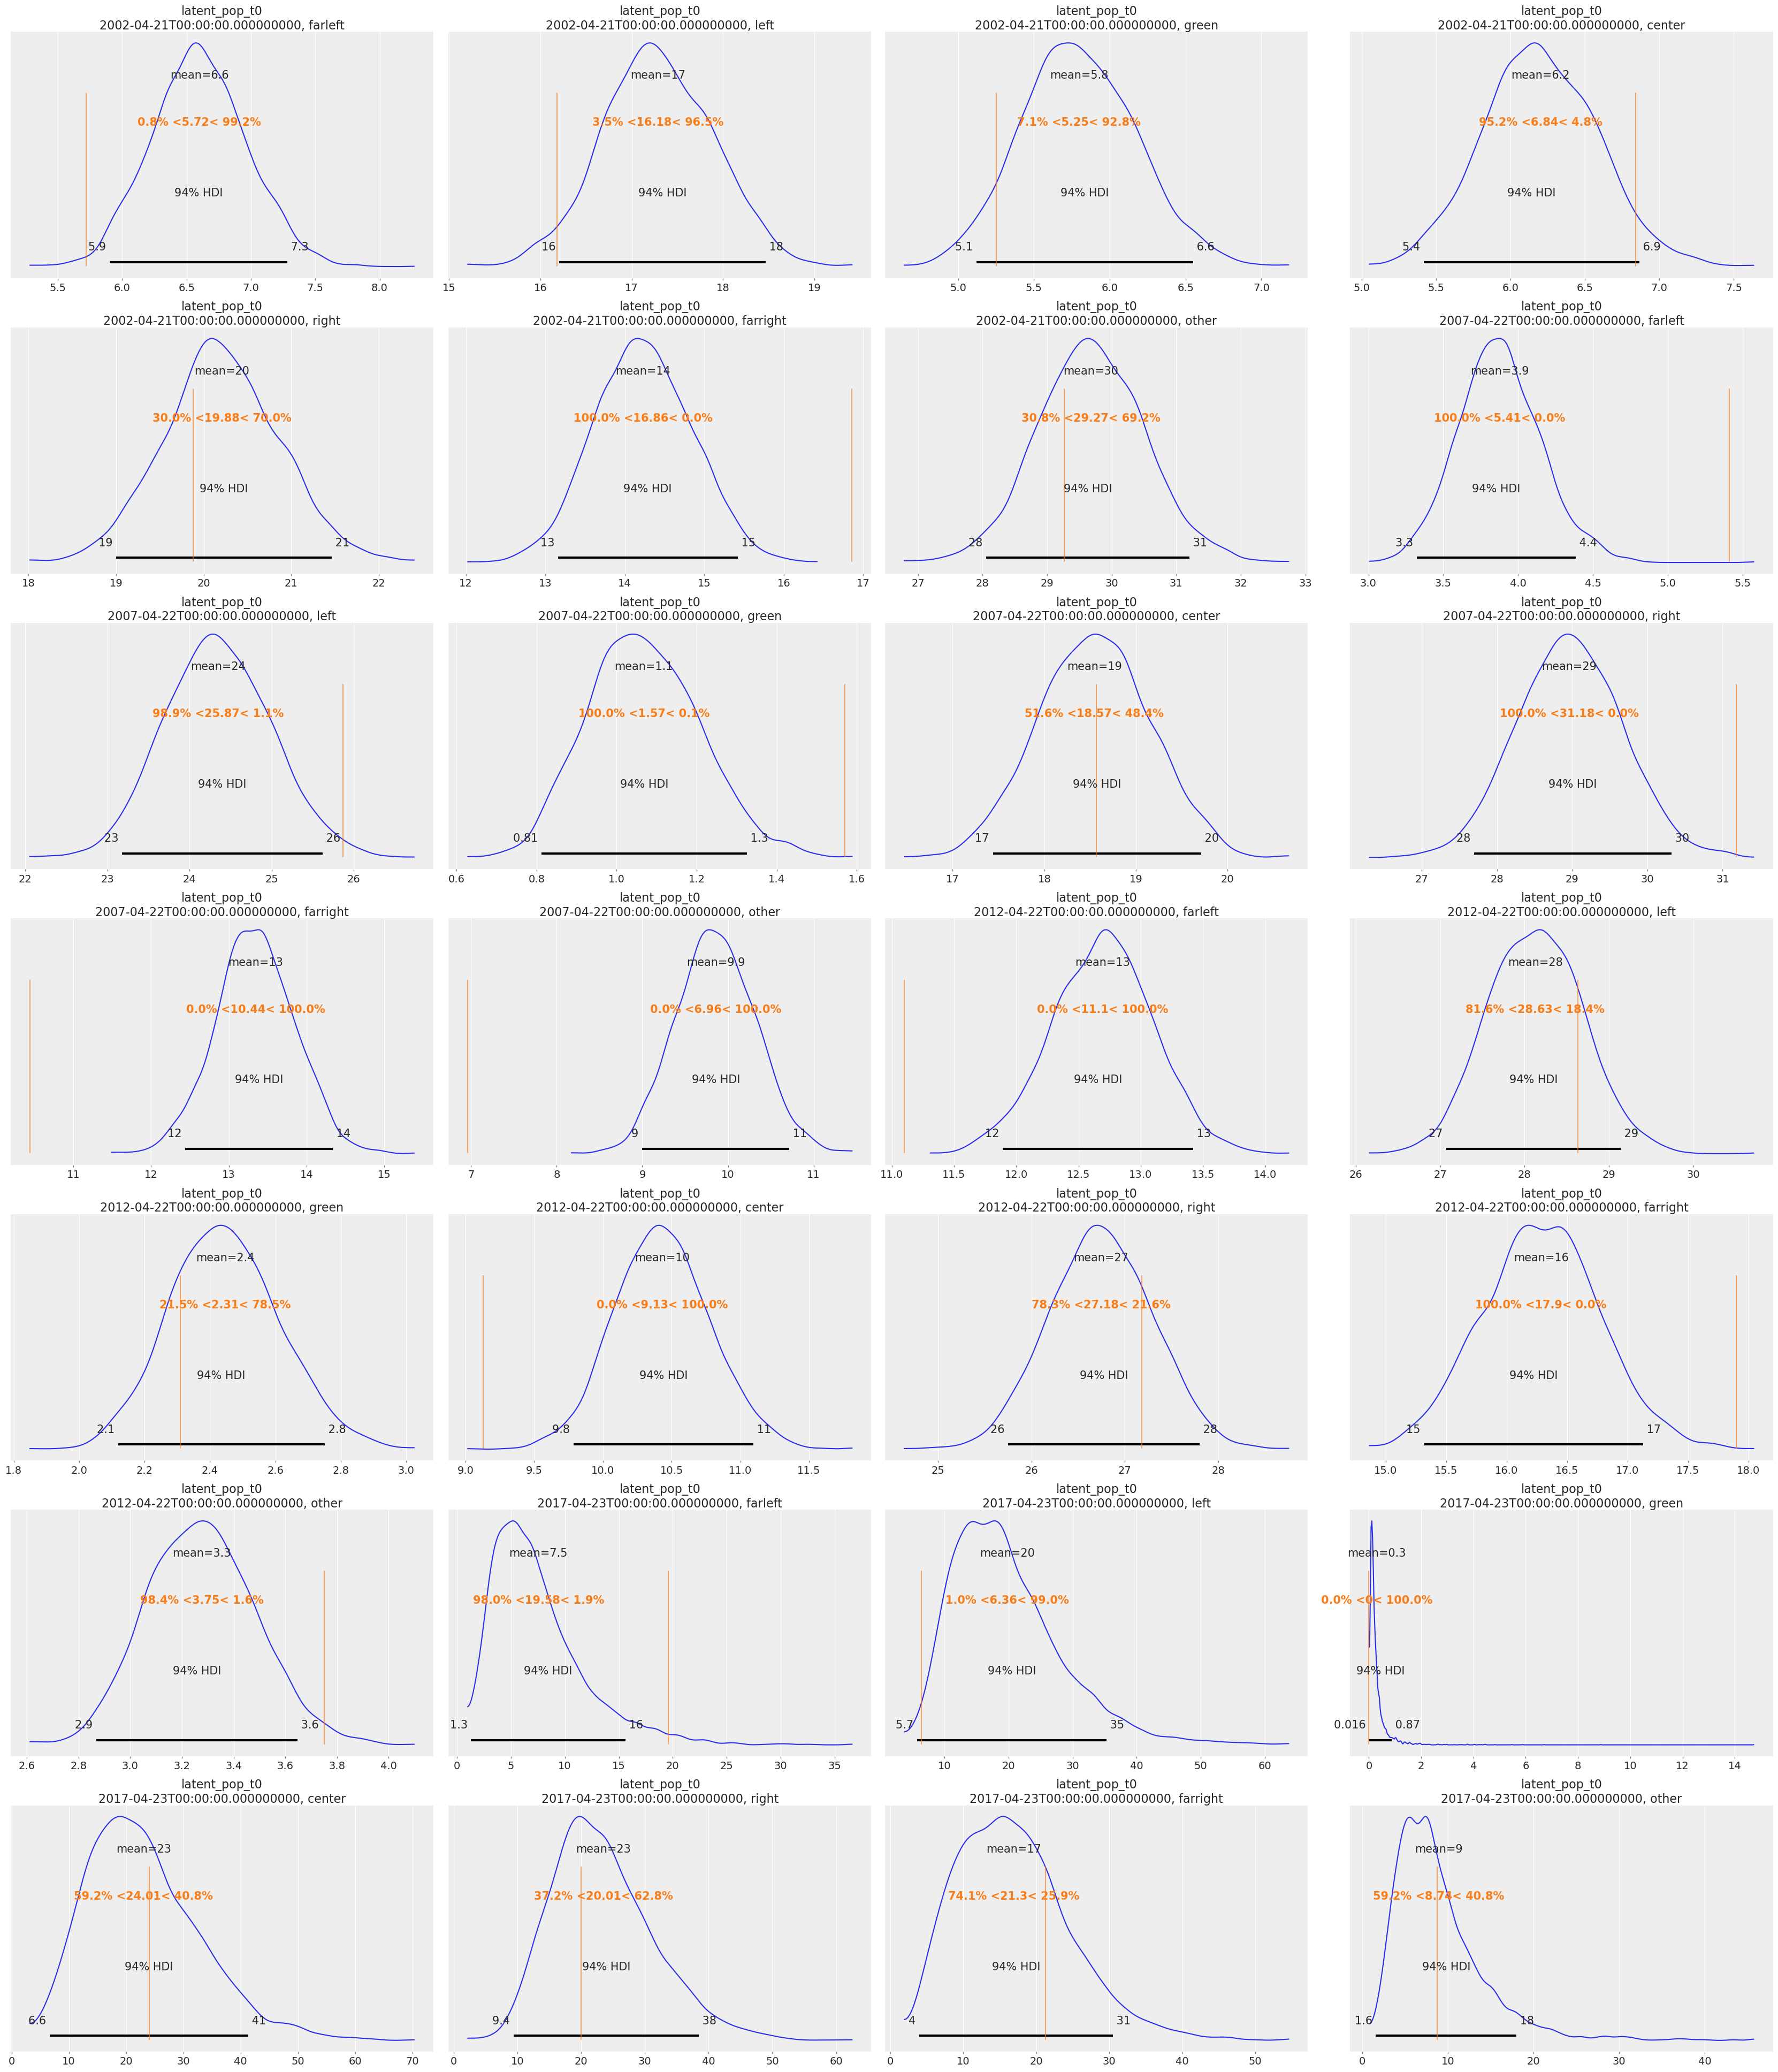

In [30]:
arviz.plot_posterior(
    election_forecast.predictions["latent_pop_t0"] * 100,
    ref_val=results[mb.parties_complete].to_numpy().flatten().tolist(),
);

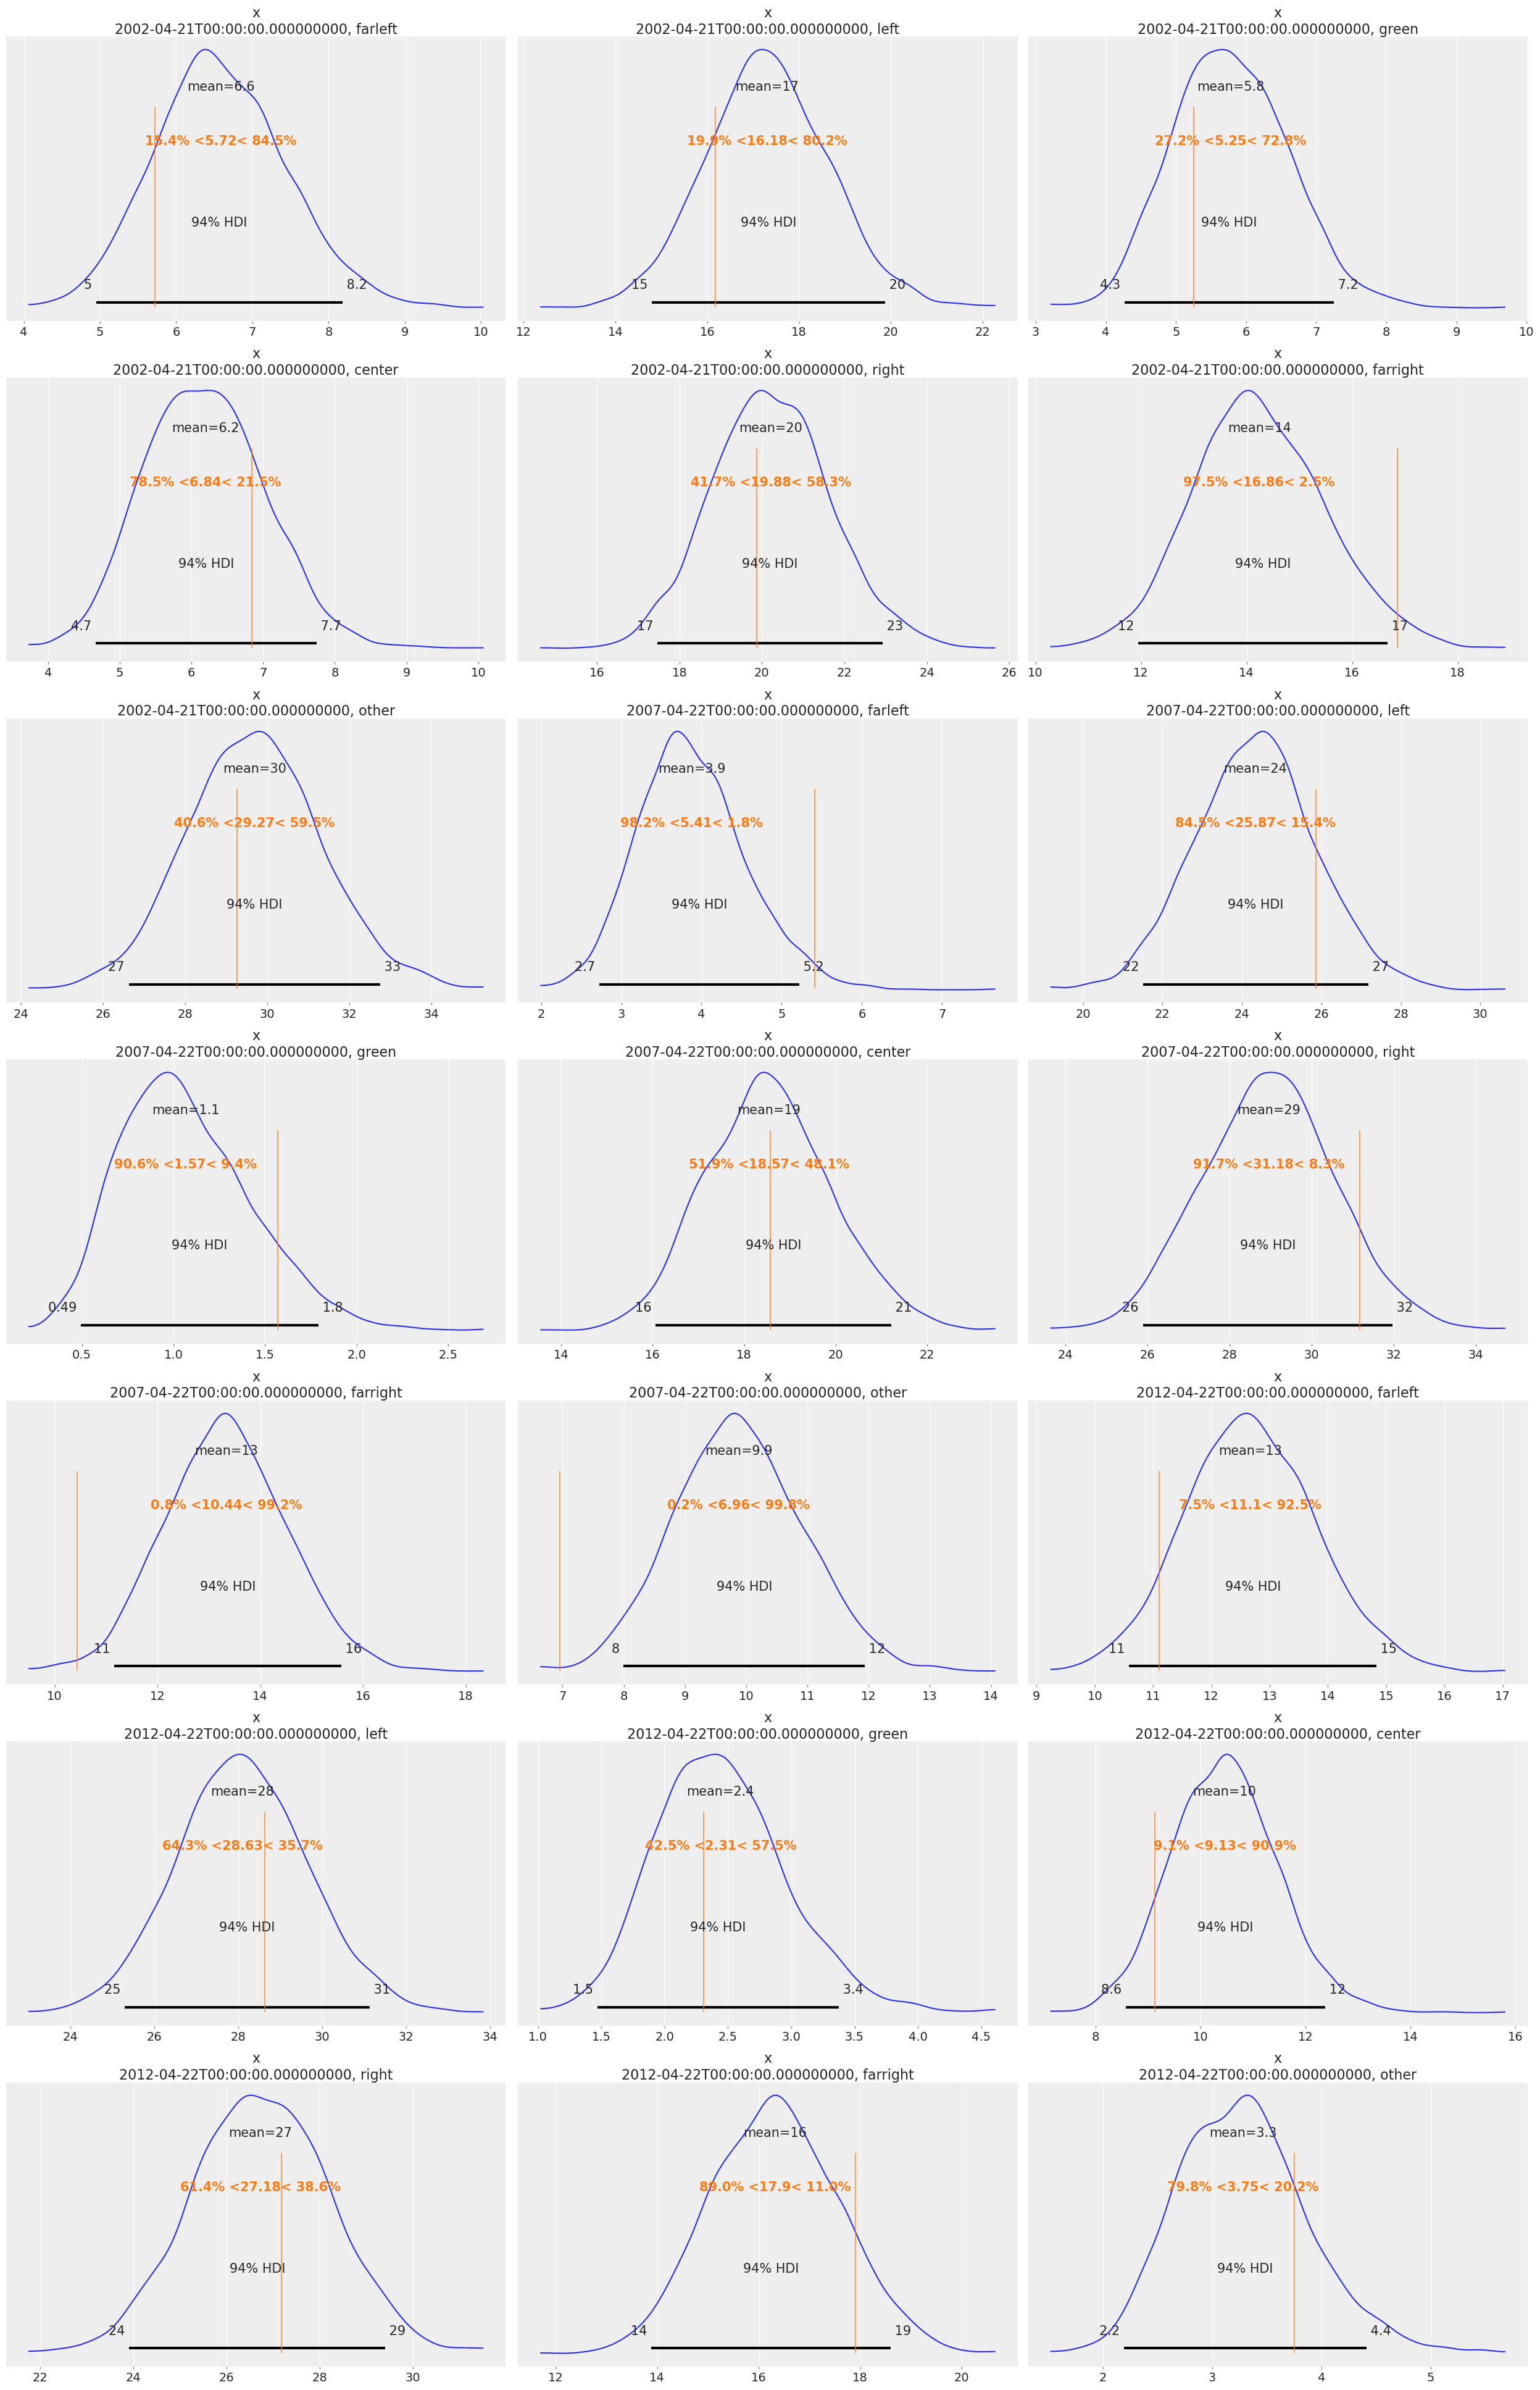

In [32]:
arviz.plot_posterior(
    (
        election_forecast.predictions["R"]
        / election_forecast.predictions_constant_data["results_N"]
    )
    * 100,
    ref_val=results[mb.parties_complete].to_numpy().flatten().tolist(),
);
# plt.savefig("ppc_results.png");

In [26]:
# covarying GP (transition matrix)

In [ ]:
# https://www.itl.nist.gov/div898/handbook/eda/section3/qqplot.htm
# add other election types (https://github.com/pollsposition/models/blob/master/district-level/munic_model_prod.ipynb)